<a href="https://colab.research.google.com/github/akhilvjose/Behavioral-Cloning/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wget

  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import zipfile


In [4]:
wget.download("https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip")


'data.zip'

In [0]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
  zip_ref.extractall('data')

In [0]:
#!git clone https://github.com/rslim087a/track.git

In [6]:
!ls data/data


driving_log.csv  IMG


In [7]:
import tensorflow as tf
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D, ELU
from keras.layers.convolutional import Convolution2D
from scipy.misc import imread, imsave
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random


Using TensorFlow backend.


In [0]:
def get_image(csv_line, data):
  positions=['left','center','right']
  corrections=[0.25, 0 ,-0.25] 
  index = data.index[csv_line]
  r=random.choice([0,1,2])
  measurement = data['steering'][index]+corrections[r]
  path = PATH + data[positions[r]][index][1:]
  if r == 1: path = PATH + data[positions[r]][index]
  image = imread(path)
  if random.random() > 0.5:
    image, measurement = np.fliplr(image), -measurement
  return image, measurement

In [0]:
def generator(csv_data, batch_size):

  while True:

    num_data = len(csv_data)
    positions=['left','center','right']
    corrections=[0.25, 0 ,-0.25]
    #csv_data.sample(frac=1)
    # itrate through batches
    for start in range(0, num_data, batch_size):
      images, measurements = [], []
      # itrate inside the batch
      for csv_line in range(start, start + batch_size):
        if csv_line < num_data:
          index = csv_data.index[csv_line]
          r=random.choice([0,1,2])
          measurement = csv_data['steering'][index]+corrections[r] # assing random corrections to angle (under steering head)
          path = PATH + csv_data[positions[r]][index][1:] # left, right
          if r == 1:path = PATH + csv_data[positions[r]][index] #center
          image = imread(path)
          if random.random() > 0.5:
            measurements.append(-measurement) #flip measurement
            images.append(np.fliplr(image)) #flip image

      yield np.array(images), np.array(measurements)

In [0]:
def generate_samples(csv_data, batch_size):

  while True:

    num_data = len(csv_data)
    #csv_data.sample(frac=1)
    # itrate through batches
    for start in range(0, num_data, batch_size):
      images, measurements = [], []
      # itrate inside the batch
      for csv_line in range(start, start + batch_size):
        if csv_line < num_data:
          image, measurement = get_image(csv_line, csv_data)
          measurements.append(measurement)
          images.append(image)

      yield np.array(images), np.array(measurements)

In [19]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255) - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape = (160, 320, 3)))
model.add(Convolution2D(16, 8, 8, subsample = (4, 4), border_mode = "same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample = (2, 2), border_mode = "same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample = (2, 2), border_mode = "same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample = (2, 2), border_mode = "same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

model.summary()
model.compile(optimizer = "adam", loss = "mse")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 80, 16)        3088      
_________________________________________________________________
elu_7 (ELU)                  (None, 17, 80, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 40, 32)         12832     
_________________________________________________________________
elu_8 (ELU)                  (None, 9, 40, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 20, 32)         25632     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), strides=(4, 4), padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2), padding="same")`
  # This is added back by InteractiveShellApp.init_path()


In [22]:
batch_size = 64
epochs = 25
PATH = "data/data/"
csv_name = "driving_log.csv"

X_data = pd.read_csv(PATH + csv_name, usecols = [0, 1, 2, 3])

X_train, X_valid = train_test_split(X_data, test_size = 0.20)
num_train = len(X_train)
num_valid = len(X_valid)
X_data.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


<Container object of 25 artists>

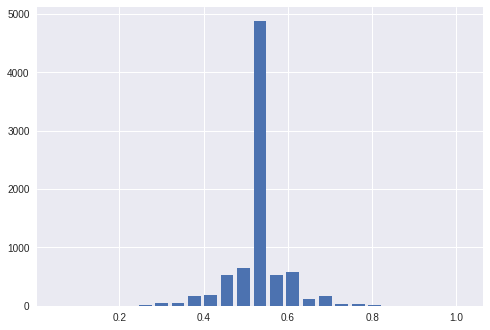

In [0]:
import matplotlib.pyplot as plt
num_bins=25
measurement = X_data['steering']
hist,bins=np.histogram(measurement,num_bins)
centered= (bins[-1]+bins[1:])*0.5
plt.bar(centered,hist,width=0.03)

In [23]:
print('Training model...')

training_generator = generate_samples(X_train, batch_size)
validation_generator = generate_samples(X_valid, batch_size)



history_object = model.fit_generator(training_generator,
                 samples_per_epoch = int(num_train/batch_size),
                 #samples_per_epoch = num_train,
                 validation_data = validation_generator,
                 nb_val_samples = int (num_valid/batch_size),
                 #nb_val_samples = num_valid,
                 nb_epoch = epochs,
                 verbose = 1)

Training model...
Epoch 1/25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, steps_per_epoch=100, epochs=25, validation_steps=25)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imag

100/100 [==============================] - 15s 149ms/step - loss: 0.0244 - val_loss: 0.0224
Epoch 2/25
100/100 [==============================] - 14s 140ms/step - loss: 0.0227 - val_loss: 0.0228
Epoch 3/25
100/100 [==============================] - 14s 139ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 4/25
100/100 [==============================] - 14s 139ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 5/25
100/100 [==============================] - 14s 139ms/step - loss: 0.0226 - val_loss: 0.0203
Epoch 6/25
100/100 [==============================] - 14s 139ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 7/25
100/100 [==============================] - 14s 140ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 8/25
100/100 [==============================] - 14s 141ms/step - loss: 0.0207 - val_loss: 0.0219
Epoch 9/25
100/100 [==============================] - 14s 141ms/step - loss: 0.0207 - val_loss: 0.0231
Epoch 10/25
100/100 [==============================] - 14s 140ms/step - loss: 0.0206

In [0]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])